### Baby-sitting the Learning Process

#### Defining the Fully Connected Layer

In [0]:
import numpy as np 

class Linear():
    def __init__(self, in_size, out_size):
        self.W = np.random.randn(in_size, out_size) * 0.01
        self.b = np.zeros((1, out_size))
        self.params = [self.W, self.b]
        self.gradW = None
        self.gradB = None
        self.gradInput = None

    def forward(self, X):
        self.X = X
        output = np.dot(self.X, self.W) + self.b
        return output

    def backward(self, nextgrad):
        self.gradW = np.dot(self.X.T, nextgrad)
        self.gradB = np.sum(nextgrad, axis=0)
        self.gradInput = np.dot(nextgrad, self.W.T)
        return self.gradInput, [self.gradW, self.gradB]

#### Defining the Rectified Linear Activation Layer


In [0]:
class ReLU():
    def __init__(self):
        self.params = []
        self.gradInput = None

    def forward(self, X):
        self.output = np.maximum(X, 0)
        return self.output

    def backward(self, nextgrad):
        self.gradInput = nextgrad.copy()
        self.gradInput[self.output <=0] = 0
        return self.gradInput, []

#### Defining the softmax function

In [0]:
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

#### Defining the Cross Entropy Loss

In [0]:
class CrossEntropy:
    def forward(self, X, y):
        self.m = y.shape[0]
        self.p = softmax(X)
        cross_entropy = -np.log(self.p[range(self.m), y]+1e-16)
        loss = np.sum(cross_entropy) / self.m
        return loss
    
    def backward(self, X, y):
        y_idx = y.argmax()        
        grad = softmax(X)
        grad[range(self.m), y] -= 1
        grad /= self.m
        return grad

### Loading the dataset : Lets us load the training and the test data and check the size of the tensors. Lets us also display the first few images from the training set.

In [53]:
from keras.datasets import mnist
from keras.utils import np_utils


(train_features, train_targets), (test_features, test_targets) = mnist.load_data()

train_features = train_features.reshape(60000, 784)
print train_features.shape
test_features = test_features.reshape(10000, 784)
print test_features.shape


# # normalize inputs from 0-255 to 0-1
train_features = train_features / 255.0
test_features = test_features / 255.0

print train_targets.shape
print test_targets.shape

X_train = train_features
y_train = train_targets

X_val = test_features
y_val = test_targets

(60000, 784)
(10000, 784)
(60000,)
(10000,)


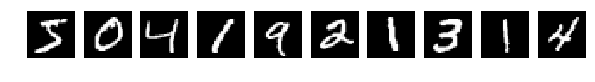

label for each of the above image: [5 0 4 1 9 2 1 3 1 4]


In [54]:
# visualizing the first 10 images in the dataset and their labels
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 1))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i].reshape(28, 28), cmap="gray")
    plt.axis('off')
plt.show()
print('label for each of the above image: %s' % (y_train[0:10]))

### Here, I define the container NN class that enables the forward prop and backward propagation of the entire network. Note, how this class enables us to add layers of different types and also correctly pass gradients using the chain rule.

In [0]:
class NN():
    def __init__(self, lossfunc=CrossEntropy(), mode='train'):
        self.params = []
        self.layers = []
        self.loss_func = lossfunc
        self.grads = []
        self.mode = mode
        
    def add_layer(self, layer):
        self.layers.append(layer)
        self.params.append(layer.params)

    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X
    
    def backward(self, nextgrad):
        self.clear_grad_param()
        for layer in reversed(self.layers):
            nextgrad, grad = layer.backward(nextgrad)
            self.grads.append(grad)
        return self.grads
    
    def train_step(self, X, y):
        out = self.forward(X)
        loss = self.loss_func.forward(out,y)  + ((Lambda / (2 * y.shape[0])) * np.sum([np.sum(w**2) for w in self.params[0][0]]))
        nextgrad = self.loss_func.backward(out,y) + ((Lambda/y.shape[0]) * np.sum([np.sum(w) for w in self.params[0][0]]))
        grads = self.backward(nextgrad)
        return loss, grads
    
    def predict(self, X):
        X = self.forward(X)
        p = softmax(X)
        return np.argmax(p, axis=1)
    
    def predict_scores(self, X):
        X = self.forward(X)
        p = softmax(X)
        return p
    
    def clear_grad_param(self):
        self.grads = []

#### Defining the update function (SGD)

In [0]:
def update(velocity, params, grads, learning_rate=0.01, mu=0.9):
    for v, p, g, in zip(velocity, params, reversed(grads)):
        for i in range(len(g)):
            v[i] = (mu * v[i]) - (learning_rate * g[i])
            p[i] += v[i]

#### Defining a function which gives us the minibatches (both the datapoint and the corresponding label)

In [0]:
# get minibatches
def minibatch(X, y, minibatch_size):
    n = X.shape[0]
    minibatches = []
    permutation = np.random.permutation(X.shape[0])
    X = X[permutation]
    y = y[permutation]
    
    for i in range(0, n , minibatch_size):
        X_batch = X[i:i + minibatch_size, :]
        y_batch = y[i:i + minibatch_size, ]

        minibatches.append((X_batch, y_batch))
    return minibatches

#### The traning loop

In [0]:
def sgd(net, X_train, y_train, minibatch_size, epoch, learning_rate, mu=0.9, X_val=None, y_val=None, Lambda=0, verb=True):
    val_loss_epoch = []
    minibatches = minibatch(X_train, y_train, minibatch_size)
    minibatches_val = minibatch(X_val, y_val, minibatch_size)
    
    for i in range(epoch):
        loss_batch = []
        val_loss_batch = []
        velocity = []
        for param_layer in net.params:
            p = [np.zeros_like(param) for param in list(param_layer)]
            velocity.append(p)
            
        # iterate over mini batches
        for X_mini, y_mini in minibatches:
            loss, grads = net.train_step(X_mini, y_mini)
            loss_batch.append(loss)
            update(velocity, net.params, grads, learning_rate=learning_rate, mu=mu)

        for X_mini_val, y_mini_val in minibatches_val:
            val_loss, _ = net.train_step(X_mini, y_mini)
            val_loss_batch.append(val_loss)
        
        # accuracy of model at end of epoch after all mini batch updates
        m_train = X_train.shape[0]
        m_val = X_val.shape[0]
        y_train_pred = []
        y_val_pred = []
        y_train1 = []
        y_vall = []
        for ii in range(0, m_train, minibatch_size):
            X_tr = X_train[ii:ii + minibatch_size, : ]
            y_tr = y_train[ii:ii + minibatch_size,]
            y_train1 = np.append(y_train1, y_tr)
            y_train_pred = np.append(y_train_pred, net.predict(X_tr))

        for ii in range(0, m_val, minibatch_size):
            X_va = X_val[ii:ii + minibatch_size, : ]
            y_va = y_val[ii:ii + minibatch_size,]
            y_vall = np.append(y_vall, y_va)
            y_val_pred = np.append(y_val_pred, net.predict(X_va))
            
        train_acc = check_accuracy(y_train1, y_train_pred)
        val_acc = check_accuracy(y_vall, y_val_pred)
        
        ## weights
        w = np.array(net.params[0][0])
        
        ## adding regularization to cost
        mean_train_loss = (sum(loss_batch) / float(len(loss_batch)))
        mean_val_loss = sum(val_loss_batch) / float(len(val_loss_batch))
        
        val_loss_epoch.append(mean_val_loss)
        if verb:
            if i%50==0:
                print("Epoch {3}/{4}: Loss = {0} | Training Accuracy = {1}".format(mean_train_loss, train_acc, val_acc, i, epoch))
    return net, val_acc

#### Checking the accuracy of the model 

In [0]:
def check_accuracy(y_true, y_pred):
    count = 0
    for i,j in zip(y_true, y_pred):
        if int(i)==j:
            count +=1
    return float(count)/float(len(y_true))

#### Invoking all that we have created until now

In [0]:
from random import shuffle


## input size
input_dim = X_train.shape[1]

def train_and_test_loop(iterations, lr, Lambda, verb=True):
    ## hyperparameters
    iterations = iterations
    learning_rate = lr
    hidden_nodes = 10
    output_nodes = 10

    ## define neural net
    nn = NN()
    nn.add_layer(Linear(input_dim, hidden_nodes))

    nn, val_acc = sgd(nn, X_train , y_train, minibatch_size=1000, epoch=iterations, learning_rate=learning_rate,\
                      X_val=X_val, y_val=y_val, Lambda=Lambda, verb=verb)
    return val_acc

### Double Check that the loss is reasonable : Disable the regularization

In [0]:
# lr = 0.00001
# Lambda = 0
# train_and_test_loop(1, lr, Lambda)

Is the loss range correct?? What about accuracy, does it make sense for an untrained network?

### Now, lets crank up the Lambda(Regularization)and check what it does to our loss function.

In [0]:
# lr = 0.00001
# Lambda = 1e3
# train_and_test_loop(1, lr, Lambda)

loss went up. Good! (Another sanity check)

### Now, lets overfit to a small subset of our dataset, in this case 20 images.

In [0]:
X_train_subset = X_train[0:20]

In [0]:
y_train_subset = y_train[0:20]

In [0]:
X_train = X_train_subset
y_train = y_train_subset

In [66]:
X_train.shape

(20, 784)

In [67]:
y_train.shape

(20,)

In the code below:
- Take the first 20 examples from MNIST
- turn off regularization(reg=0.0)
- use simple vanilla 'sgd'

In [0]:
# lr = 0.0001
# Lambda = 0
# train_and_test_loop(10000, lr, Lambda)

### Loading the original dataset again

In [69]:
import pandas as pd
from keras.datasets import mnist
from keras.utils import np_utils


(train_features, train_targets), (test_features, test_targets) = mnist.load_data()

train_features = train_features.reshape(60000, 784)
print train_features.shape
test_features = test_features.reshape(10000, 784)
print test_features.shape


# # normalize inputs from 0-255 to 0-1
train_features = train_features / 255.0
test_features = test_features / 255.0

print train_targets.shape
print test_targets.shape

X_train = train_features
y_train = train_targets

X_val = test_features
y_val = test_targets

(60000, 784)
(10000, 784)
(60000,)
(10000,)


### Start with small regularization and find learning rate that makes the loss go down.

- start with Lambda(small regularization) = 1e-7
- start with a small learning rate = 1e-7

In [0]:
# lr = 1e-7
# Lambda = 1e-7
# train_and_test_loop(500, lr, Lambda)

Loss barely changing. Learning rate is probably too low.

### Okay now lets try a (larger) learning rate 1e6. What could possibly go wrong?

- Learning rate lr = 1e6
- Regularization lambda = 1e-7


In [0]:
# lr = 1e6
# Lambda = 1e-7
# train_and_test_loop(500, lr, Lambda)

Loss exploding. Learning rate is too high. 
Cost is very high. Always means high learning rate

### Lets try to train now with a value of learning rate between 1e-7 and 1e6

- learning rate = 1e4
- regularization remains the small, lambda = 1e-7

In [0]:
# lr = 1e4
# Lambda = 1e-7
# train_and_test_loop(500, lr, Lambda)

Still too high learning rate. Loss is not decreasing. The rough range of learning rate we should be cross validating is somewhere between [1e4 to 1e-7]

### Hyperparameter Optimization

### Cross validation Strategy


- Do coarse -> fine cross-validation in stages

- First stage: only a few epochs to get rough idea of what params work
- Second stage: longer running time, finer search
- … (repeat as necessary)

### Tip for detecting explosions in the solver: 
- If the cost is ever > 3 * original cost, break out early




### For example: Run coarse search for 100 iterations


In [0]:
# import math
# for k in range(1,100):
#     lr = math.pow(10, np.random.uniform(-7.0, 4.0))
#     Lambda = math.pow(10, np.random.uniform(-5,5))
#     best_acc = train_and_test_loop(100, lr, Lambda, False)
#     print("Try {0}/{1}: Best_val_acc: {2}, lr: {3}, Lambda: {4}\n".format(k, 100, best_acc, lr, Lambda))

### Now run finer search

In [74]:
import math
for k in range(1,10):
    lr = math.pow(10, np.random.uniform(-3.0, -2.0))
    Lambda = math.pow(10, np.random.uniform(-5,2))
    best_acc = train_and_test_loop(100, lr, Lambda, False)
    print("Try {0}/{1}: Best_val_acc: {2}, lr: {3}, Lambda: {4}\n".format(k, 100, best_acc, lr, Lambda))

Try 1/100: Best_val_acc: 0.9082, lr: 0.00162322285494, Lambda: 0.565211556146

Try 2/100: Best_val_acc: 0.9177, lr: 0.00520748540154, Lambda: 3.05566843017e-05

Try 3/100: Best_val_acc: 0.9093, lr: 0.00187245310409, Lambda: 0.000306033780085

Try 4/100: Best_val_acc: 0.9065, lr: 0.00148196872012, Lambda: 3.07636783878e-05

Try 5/100: Best_val_acc: 0.9043, lr: 0.00117401597512, Lambda: 1.097682628e-05



/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in square
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in subtract
  


Try 6/100: Best_val_acc: 0.098, lr: 0.00161439611737, Lambda: 3.40594576735

Try 7/100: Best_val_acc: 0.098, lr: 0.00106264850247, Lambda: 20.6484697727

Try 8/100: Best_val_acc: 0.9091, lr: 0.00183642210165, Lambda: 0.198382458737

Try 9/100: Best_val_acc: 0.098, lr: 0.00498456291836, Lambda: 0.992582560927

